<a href="https://colab.research.google.com/github/st064560/my_python/blob/master/RFM_analysis_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# импортируем библиотеки numpy и pandas
import numpy as np
import pandas as pd

# импортируем библиотеку datetime для работы с датами
import datetime
from datetime import datetime, date

# импортируем библиотеку matplotlib для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline

RFM-анализ — метод анализа, позволяющий сегментировать клиентов по частоте и сумме покупок и выявлять тех клиентов, которые приносят больше денег.


*   **Recency** — давность (как давно ваши клиенты что-то у вас покупали);
*   **Frequency** — частота (как часто они у вас покупают);


*   **Monetary** — деньги (общая сумма покупок).




По этим признакам можно разделить всех ваших клиентов на группы, понять, кто из клиентов покупает у вас часто и много, кто — часто, но мало, а кто вообще давно ничего не покупал.

In [2]:
#представим данные в виду датафрэйма
df = pd.read_excel('orders_2019 only.xlsx')
#df.head(5)

In [5]:
data = df[['Номер Заказа', 'дата заказа', 'Статус заказа', 'email', 'ЦЕНА ДО СКИДКИ SUM, RUR']]
#data.head(2)

In [6]:
data['ID'] = data['email'].astype('category').cat.codes 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:

data = data.rename(columns={"Номер Заказа": "order", "дата заказа": "order_date",  "Статус заказа": "status",  "ЦЕНА ДО СКИДКИ SUM, RUR": "price"})

In [8]:
data.head(3)

,order,order_date,status,email,price,ID
0,131855779,2019-01-01,complete,alekseev.gm@yandex.ru,1348.330,5811
1,131855782,2019-01-01,complete,5reasons@mail.ru,3862.889,903
2,131855786,2019-01-01,canceled,sveta.petrenko36@mail.ru,6616.670,37821


In [9]:
data = data[(data.status == 'complete')]

In [10]:
#data.head(5)

In [11]:
print(data['order_date'].min(), data['order_date'].max())

2019-01-01 00:00:00 2019-12-31 00:00:00


In [13]:
import datetime as dt
sd = dt.datetime(2020,1,1)
data['hist']=sd - data['order_date']
data['hist'].astype('timedelta64[D]')
data['hist']=data['hist'] / np.timedelta64(1, 'D')
data.head(3)

,order,order_date,status,email,price,ID,hist
0,131855779,2019-01-01,complete,alekseev.gm@yandex.ru,1348.330,5811,365.0
1,131855782,2019-01-01,complete,5reasons@mail.ru,3862.889,903,365.0
3,131855787,2019-01-01,complete,vialex0804@yandex.ru,9621.660,41468,365.0


In [90]:
data.to_excel('id founder.xlsx')

In [14]:
print('Дата фрэйм содержит информацию о ', data.email.nunique(), 'пользователях')

Дата фрэйм содержит информацию о  41084 пользователях


In [15]:
rfmTable = data.groupby('ID').agg({'hist': lambda x:x.min(), # Recency
                                        'ID': lambda x: len(x),               # Frequency
                                        'price': lambda x: x.sum()})          # Monetary Value

rfmTable.rename(columns={'hist': 'recency', 
                         'ID': 'frequency', 
                         'price': 'monetary_value'}, inplace=True)

На основе данных создадим столбцы RFM для каждого, кто соверашал покупку в 2019 году

In [16]:
rfmTable.head(6)

,recency,frequency,monetary_value
ID,,,
0,279.0,1,3234.9045
1,62.0,1,415.8000
2,344.0,1,956.6700
3,251.0,1,3950.4250
4,27.0,1,2525.8300
5,11.0,4,18561.5055


In [17]:
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      recency  frequency  monetary_value
0.25     40.0        1.0      2229.16000
0.50    113.0        1.0      3592.29500
0.75    221.0        2.0      6515.40475 <class 'pandas.core.frame.DataFrame'>


In [ ]:
Для того чтобы оценить получившиеся значения разделим данные на 4 квартиля (адаптированные для каждой категории)

In [18]:
quartiles=quartiles.to_dict()
quartiles

{'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'monetary_value': {0.25: 2229.16, 0.5: 3592.295, 0.75: 6515.40475},
 'recency': {0.25: 40.0, 0.5: 113.0, 0.75: 221.0}}

In [19]:
## for Recency 

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [20]:
## for Frequency and Monetary value 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1  

На основе значений картилей мы выстраим дальнейшую оценку пользователя. Шкала - по убывающей (оценка 1 - лучшая)

In [21]:
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

In [22]:
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

In [25]:
rfmSeg.head(10)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
ID,,,,,,,
0,279.0,1,3234.9045,4,4,3,443
1,62.0,1,415.8000,2,4,4,244
2,344.0,1,956.6700,4,4,4,444
3,251.0,1,3950.4250,4,4,2,442
4,27.0,1,2525.8300,1,4,3,143
5,11.0,4,18561.5055,1,1,1,111
6,117.0,2,6216.6700,3,2,2,322
7,118.0,2,6670.3890,3,2,1,321
8,120.0,1,2593.5681,3,4,3,343


In [31]:
rfmSeg.to_excel('rfmSeg_table_2019.xlsx')

In [24]:
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
ID,,,,,,,
4471,13.0,9,102248.8700,1,1,1,111
11373,2.0,8,99268.9050,1,1,1,111
20809,14.0,20,96871.8750,1,1,1,111
31211,40.0,9,82375.1007,1,1,1,111
35366,29.0,8,76715.0300,1,1,1,111
...,...,...,...,...,...,...,...
42381,319.0,1,0.0000,4,4,4,444
42612,283.0,1,0.0000,4,4,4,444
43436,308.0,1,0.0000,4,4,4,444


In [33]:
kp = rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])
kp.to_excel('rfmSeg.sort_2019.xlsx')

In [ ]:
Видим, что у нас таким образом получилось достаточно много сегментов (которые, в принципе, тоже можно использовать)
Для того чтобы сократить кол-во сегментов сложим значения квартилей

In [26]:
rfmSeg.groupby('RFMClass').agg('monetary_value').mean()

RFMClass
111    18674.342665
112     5278.615278
113     3047.031214
114     1562.625875
121     9651.585155
122     5166.679816
123     3054.029900
124     1719.012911
141     8712.832111
142     4618.924877
143     2804.190810
144     1541.246329
211    16468.054627
212     5297.298510
213     2931.898124
214     1278.620271
221    10109.960394
222     5166.213745
223     2968.890815
224     1407.534586
241     8108.205464
242     4638.650340
243     2916.794682
244     1261.751238
311    14837.474489
312     5340.267071
313     3108.731750
314     1236.608743
321     9612.123423
322     5203.232463
323     2974.697720
324     1353.871293
341     8269.629648
342     4552.575375
343     2945.776816
344     1366.122314
411    14087.559363
412     5077.635105
413     2722.697100
414     1150.438500
421     9562.072889
422     5227.784045
423     2939.507952
424     1119.515491
441     8604.860254
442     4562.677367
443     3013.362607
444     1196.817338
Name: monetary_value, dtype: fl

In [28]:
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
print(rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41084 entries, 0 to 44269
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         41084 non-null  float64
 1   frequency       41084 non-null  int32  
 2   monetary_value  41084 non-null  float64
 3   R_Quartile      41084 non-null  int64  
 4   F_Quartile      41084 non-null  int64  
 5   M_Quartile      41084 non-null  int64  
 6   RFMClass        41084 non-null  object 
 7   Total Score     41084 non-null  int64  
dtypes: float64(2), int32(1), int64(4), object(1)
memory usage: 2.7+ MB
    recency  frequency  monetary_value  ...  M_Quartile  RFMClass  Total Score
ID                                      ...                                   
0     279.0          1       3234.9045  ...           3       443           11
1      62.0          1        415.8000  ...           4       244           10
2     344.0          1        956.6700  ...           

In [29]:
rfmSeg.groupby('Total Score').agg('monetary_value').mean()

Total Score
3     18674.342665
4     13590.804896
5      9943.643958
6      7832.103247
7      5740.587734
8      4008.896012
9      3437.430894
10     2998.754237
11     2217.231903
12     1196.817338
Name: monetary_value, dtype: float64

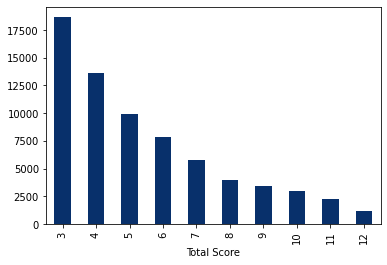

In [30]:
rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')

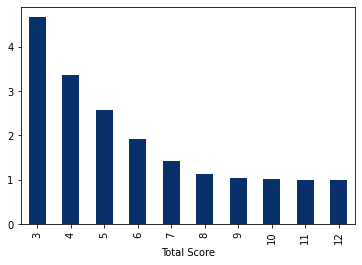

In [31]:
rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')

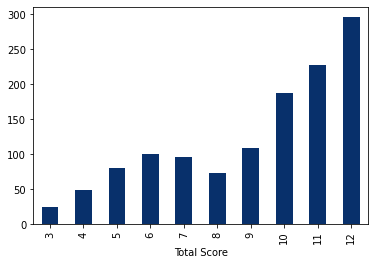

In [32]:
rfmSeg.groupby('Total Score').agg('recency').mean().plot(kind='bar', colormap='Blues_r')

NEW **ANALYSIS**

In [33]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt


In [43]:
!pip install squarify

In [34]:
rfmTable.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score
ID,,,,,,,,
0,279.0,1,3234.9045,4,4,3,443,11
1,62.0,1,415.8000,2,4,4,244,10
2,344.0,1,956.6700,4,4,4,444,12
3,251.0,1,3950.4250,4,4,2,442,10
4,27.0,1,2525.8300,1,4,3,143,8


In [35]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


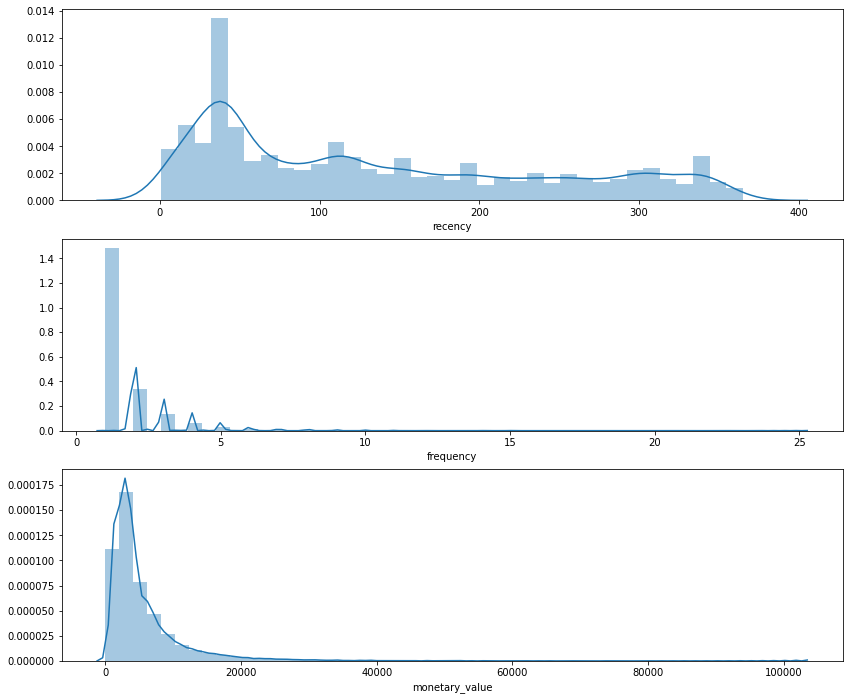

In [36]:
plt.figure(figsize=(14,12))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfmTable['recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfmTable['frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfmTable['monetary_value'])
# Show the plot
plt.savefig('distrib_graph.png')
plt.show()

In [39]:
# Define rfm_level function
def rfm_level(df):
    if df['Total Score'] >= 9:
        return 'Require Activation'
    elif ((df['Total Score'] >= 8) and (df['Total Score'] < 9)):
        return 'Needs Attention'
    elif ((df['Total Score'] >= 7) and (df['Total Score'] < 8)):
        return 'Promising'
    elif ((df['Total Score'] >= 6) and (df['Total Score'] < 7)):
        return 'Potential'
    elif ((df['Total Score'] >= 5) and (df['Total Score'] < 6)):
        return 'Loyal'
    elif ((df['Total Score'] >= 4) and (df['Total Score'] < 5)):
        return 'Champions'
    else:
        return 'Can\'t Loose Them'
# Create a new variable RFM_Level
rfmSeg['RFM_Level'] = rfmSeg.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfmSeg.head(15)


,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,RFM_Level
ID,,,,,,,,,
0,279.0,1,3234.9045,4,4,3,443,11,Require Activation
1,62.0,1,415.8000,2,4,4,244,10,Require Activation
2,344.0,1,956.6700,4,4,4,444,12,Require Activation
3,251.0,1,3950.4250,4,4,2,442,10,Require Activation
4,27.0,1,2525.8300,1,4,3,143,8,Needs Attention
5,11.0,4,18561.5055,1,1,1,111,3,Can't Loose Them
6,117.0,2,6216.6700,3,2,2,322,7,Promising
7,118.0,2,6670.3890,3,2,1,321,6,Potential
8,120.0,1,2593.5681,3,4,3,343,10,Require Activation


In [40]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfmSeg.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   recency frequency monetary_value       
                      mean      mean           mean  count
RFM_Level                                                 
Can't Loose Them      24.6       4.7        18674.3   1956
Champions             48.3       3.4        13590.8   2760
Loyal                 80.7       2.6         9943.6   2633
Needs Attention       73.6       1.1         4008.9   4832
Potential            100.4       1.9         7832.1   2607
Promising             95.6       1.4         5740.6   3779
Require Activation   187.1       1.0         2735.4  22517


In [45]:
rfm_level_agg.to_excel('rfm_table.xlsx')

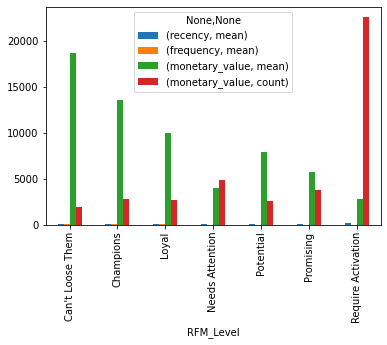

In [50]:
rfm_level_agg.plot.bar()